In [1]:
import torch
import numpy as np
attn = torch.load("/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/draft1.pt").to('cpu')
print(attn.shape)

torch.Size([1, 32, 60, 222])


In [2]:
def extract_zero(attn_weights:torch.Tensor):
    iszero = attn_weights < 0.01
    zeroindex = torch.all(iszero,dim=1)
    print(zeroindex.shape)
    # for i in np.array(zeroindex).tolist()[0]:
    #     print(i)
    print(zeroindex.sum(dim=-1))
    
extract_zero(attn)

torch.Size([1, 60, 222])
tensor([[100,  99, 124, 113, 123, 122, 117, 118, 106, 107, 117, 116, 110, 122,
         119, 113, 125,  99,  96,  90, 102,  95, 100, 104, 115,  95,  97,  99,
          98,  98, 110, 118,  94,  74,  86,  80,  98, 111, 109,  93, 111,  98,
          97,  73,  84,  88,  84,  84,  78,  92,  92,  88, 102, 102, 108, 110,
         117, 114, 115, 115]])


[ 992 -> 1024 );[ 30 ); length: 383 

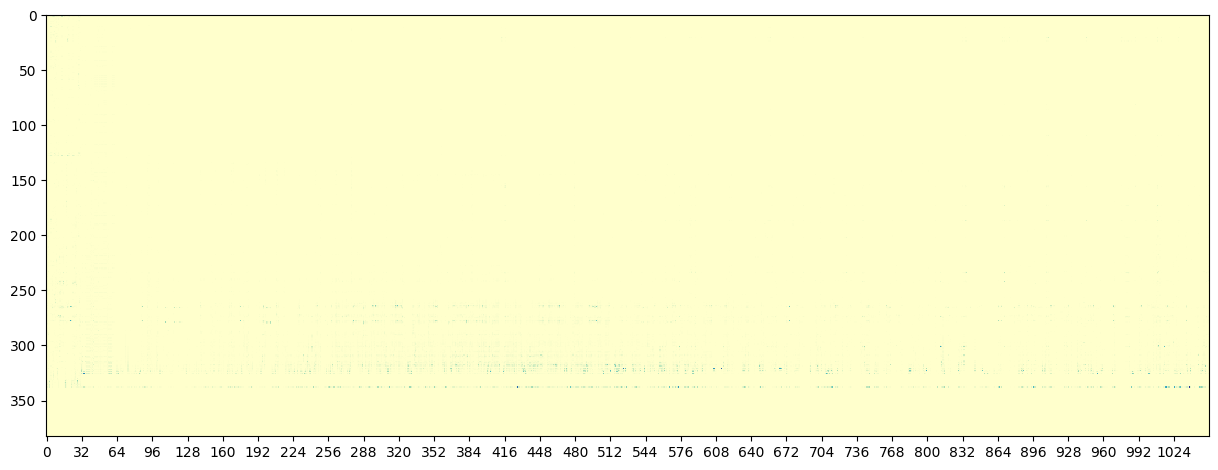

basemodel
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7267
num_important_columns: tensor([  0, 318, 321, 323, 338])
Average number of important columns: 5.00
draft
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.5341
num_important_columns: tensor([  0,   2, 128, 265, 266, 335, 336, 338])
Average number of important columns: 8.00


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]  # Define custom colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)  # Create custom colormap

def count_importance(attn_weights: torch.Tensor,selecttoken=None):
    imps = []

    for i in range(selecttoken,selecttoken+1):  # 默认处理第一个 head
        head_attn = attn_weights[ :, :, i, :].reshape(-1, attn_weights.shape[3])  # shape: (N, seq_len)

        # 布尔张量：大于0.05的元素
        aboveattn = head_attn > 0.05  # shape: (N, seq_len)

        # 每列中 >0.05 的占比
        abovecount = aboveattn.to(dtype=torch.float64).mean(dim=0)  # shape: (seq_len,)

        # 找出重要列（即 >0.05 占比超过0.1 的列）
        important_indices = (abovecount > 0.1).nonzero(as_tuple=True)[0]  # shape: (num_important_cols,)

        # 分子：这些重要列中，>0.05 的元素数量
        important_column_mask = aboveattn[:, important_indices]
        num_important_above = important_column_mask.sum().item()

        # 分母：所有 >0.05 的元素数量
        total_above = aboveattn.sum().item()

        # 比例计算
        if total_above > 0:
            importance_ratio = num_important_above / total_above
        else:
            importance_ratio = 0.0

        print(f'importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): {importance_ratio:.4f}')
        print(f'num_important_columns: {important_indices}')

        imps.append(len(important_indices))

    print(f"Average number of important columns: {sum(imps) / len(imps):.2f}")


def plot_attention(attn_weights, head):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    head_attn = attn_weights[0, head]  # 取 batch=0, 指定头
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    plt.colorbar()
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

def plot_attention_all_head(attn_weights:torch.Tensor,selecttoken):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    # head_attn = attn_weights.reshape(-1,attn_weights.shape[3])  # 取 batch=0, 指定头
    head_attn = attn_weights[:,:,selecttoken,:].reshape(-1,attn_weights.shape[3])  # 取 batch=0, 指定头
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    # plt.colorbar()
    plt.xticks(range(0,head_attn.shape[0],32))
    plt.savefig('hotmapattn.pdf')
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

    
def get_pipeline(startlinear,selecttoken=7):
    originarea = (startlinear+1)* 32

    origin_attn = []
    for i in range(originarea,originarea+32):
        origin_attn .append( torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/real{i}.pt").to('cpu') )
    origin_attn = torch.cat(origin_attn,dim=0)
    # print(origin_attn.shape)


    draft_attn=torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/draft{startlinear}.pt").to('cpu')
    # draft_attn = torch.stack(draft_attn)
    # print(len(draft_attn),draft_attn[0].shape)
    
    print('[',originarea,'->',originarea+32,');[',startlinear,');',end=' ')
    print('length:',origin_attn.shape[-1],end=' ')
    
    plot_attention_all_head(torch.cat([draft_attn,origin_attn],dim=0),selecttoken)
    print('basemodel')
    count_importance(origin_attn,selecttoken)
    print('draft')
    count_importance(draft_attn,selecttoken)

get_pipeline(30,15)

In [7]:
import torch
import numpy as np
attn = torch.load("/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/draft0.pt").to('cpu')
print(attn.shape)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]  # Define custom colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)  # Create custom colormap

def plot_attention(attn_weights, head):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    head_attn = attn_weights[0, head]  # 取 batch=0, 指定头
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    plt.colorbar()
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

def plot_attention_all_head(attn_weights:torch.Tensor):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    # head_attn = attn_weights.reshape(-1,attn_weights.shape[3])  # 取 batch=0, 指定头
    # head_attn = attn_weights
    head_attn = attn_weights.permute(0,2,1,3).reshape(-1,attn_weights.shape[3])
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    # plt.colorbar()
    plt.xticks(range(0,head_attn.shape[0],32))
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

# 示例：可视化 Draft Model 第 3 层、第 5 头
# plot_attention(
#     attn, 
#     head=5,
# )

def count_importance(attn_weights: torch.Tensor):
    imps = []

    for i in range(60):  # 默认处理第一个 head
        head_attn = attn_weights[ :, :, i, :].reshape(-1, attn_weights.shape[3])  # shape: (N, seq_len)

        # 布尔张量：大于0.05的元素
        aboveattn = head_attn > 0.05  # shape: (N, seq_len)

        # 每列中 >0.05 的占比
        abovecount = aboveattn.to(dtype=torch.float64).mean(dim=0)  # shape: (seq_len,)

        # 找出重要列（即 >0.05 占比超过0.1 的列）
        important_indices = (abovecount > 0.1).nonzero(as_tuple=True)[0]  # shape: (num_important_cols,)

        # 分子：这些重要列中，>0.05 的元素数量
        important_column_mask = aboveattn[:, important_indices]
        num_important_above = important_column_mask.sum().item()

        # 分母：所有 >0.05 的元素数量
        total_above = aboveattn.sum().item()

        # 比例计算
        if total_above > 0:
            importance_ratio = num_important_above / total_above
        else:
            importance_ratio = 0.0

        print(f'importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): {importance_ratio:.4f}')
        print(f'num_important_columns: {important_indices}')

        imps.append(len(important_indices))

    print(f"Average number of important columns: {sum(imps) / len(imps):.2f}")


# plot_attention_all_head(attn)

count_importance(attn)

torch.Size([1, 32, 60, 218])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7250
num_important_columns: tensor([  0,   2, 128, 142, 143, 145, 152, 158])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8148
num_important_columns: tensor([  0,   2,  59, 128, 142, 143, 152, 154, 158, 159])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7748
num_important_columns: tensor([  0,   2, 128, 142, 143, 152, 154, 158, 159, 160])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7917
num_important_columns: tensor([  0,   2, 128, 152, 158, 159, 160, 161])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7607
num_important_columns: tensor([  0,   2, 126, 128, 158, 159, 160, 161, 162])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7734
num_important_columns: tensor([  0,   2, 128, 142, 158, 159, 160, 161, 162, 163])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.6519
num_important_columns: tensor([  0,   2,  18, 128, 159, 160, 161, 163, 164])
importance_ratio (重要列中的 >0.05 元素 / 

In [6]:
import torch
import numpy as np
attns = []
for i in range(32,64):
    attns.append(torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/real{i}.pt").to('cpu'))
attns = torch.stack(attns)
print(attns.shape)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]  # Define custom colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)  # Create custom colormap

def plot_attention(attn_weights, head):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    head_attn = attn_weights[0, head]  # 取 batch=0, 指定头
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    plt.colorbar()
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

def plot_attention_all_head(attn_weights:torch.Tensor):
    # attn_weights: 当前层的注意力矩阵 [heads, seq_len, seq_len]
    # head_attn = attn_weights.reshape(-1,attn_weights.shape[3])  # 取 batch=0, 指定头
    # head_attn = attn_weights.permute(0,2,1,3)
    print(attn_weights.shape)
    head_attn = attn_weights[:,:,:,0,:].reshape(-1,attn_weights.shape[4])
    
    plt.figure(figsize=(15, 8))
    plt.imshow(head_attn.T, cmap=custom_cmap, interpolation='nearest')
    # plt.colorbar()
    plt.xticks(range(0,head_attn.shape[0],32))
    plt.show()
    # sns.heatmap(head_attn, cmap="viridis",)# xticklabels=tokens, yticklabels=tokens)
    # plt.show()

# 示例：可视化 Draft Model 第 3 层、第 5 头
# plot_attention(
#     attn, 
#     head=5,
# )

# def count_importance(attn_weights:torch.Tensor):
#     imps=[]
#     for i in range(1):
#         head_attn = attn_weights[:,:,:,i,:].reshape(-1,attn_weights.shape[4])
#         aboveattn = head_attn > 0.05
#         abovecount = aboveattn.to(dtype=torch.float64)
#         # print(abovecount.shape)
#         abovecount = abovecount.mean(dim=0)
#         print(abovecount.shape)
#         impcount = abovecount > 0.1
#         impcount = impcount.sum()
#         print('importance_rate',impcount)
#         imps.append(impcount.item())
#     print(sum(imps)/len(imps))

def count_importance(attn_weights: torch.Tensor):
    imps = []

    for i in range(60):  # 默认处理第一个 head
        head_attn = attn_weights[:, :, :, i, :].reshape(-1, attn_weights.shape[4])  # shape: (N, seq_len)

        # 布尔张量：大于0.05的元素
        aboveattn = head_attn > 0.05  # shape: (N, seq_len)

        # 每列中 >0.05 的占比
        abovecount = aboveattn.to(dtype=torch.float64).mean(dim=0)  # shape: (seq_len,)

        # 找出重要列（即 >0.05 占比超过0.1 的列）
        important_indices = (abovecount > 0.1).nonzero(as_tuple=True)[0]  # shape: (num_important_cols,)

        # 分子：这些重要列中，>0.05 的元素数量
        important_column_mask = aboveattn[:, important_indices]
        num_important_above = important_column_mask.sum().item()

        # 分母：所有 >0.05 的元素数量
        total_above = aboveattn.sum().item()

        # 比例计算
        if total_above > 0:
            importance_ratio = num_important_above / total_above
        else:
            importance_ratio = 0.0

        print(f'importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): {importance_ratio:.4f}')
        print(f'num_important_columns: {important_indices}')

        imps.append(len(important_indices))

    print(f"Average number of important columns: {sum(imps) / len(imps):.2f}")



# plot_attention_all_head(attns)

count_importance(attns)

torch.Size([32, 1, 32, 60, 218])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8184
num_important_columns: tensor([  0, 142, 157, 158])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.7919
num_important_columns: tensor([  0, 142, 158, 159])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8186
num_important_columns: tensor([  0, 142, 158, 160])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8068
num_important_columns: tensor([  0, 157, 158, 161])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8646
num_important_columns: tensor([  0, 157, 158, 162])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8541
num_important_columns: tensor([  0, 142, 158, 163])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8293
num_important_columns: tensor([  0, 142, 158, 164])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8658
num_important_columns: tensor([  0, 142, 158, 165])
importance_ratio (重要列中的 >0.05 元素 / 全体 >0.05 元素): 0.8393
num_important_columns: tensor([  0, 142, 157, 1

In [7]:
super_attn = []
for i in range(32,64):
    super_attn .append( torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/real{i}.pt").to('cpu') )
super_attn = torch.stack(super_attn)
print(super_attn.shape)

torch.Size([32, 1, 32, 60, 218])


In [8]:
def super_extract_zero(super_attn_weights:torch.Tensor):
    attn_weights = super_attn_weights.view(32*32,super_attn_weights.shape[-2],super_attn_weights.shape[-1])
    iszero = attn_weights < 0.005
    zeroindex = torch.all(iszero,dim=0)
    
    print(zeroindex.shape)
    for i in np.array(zeroindex).tolist():
        print(i)
    print(zeroindex.sum(dim=-1))
        
    return zeroindex    
    # print(zeroindex.shape)
    # for i in np.array(zeroindex).tolist()[0]:
    #     print(i)
    # print(zeroindex.sum(dim=-1))
    
super_extract_zero(super_attn)

torch.Size([60, 218])
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        ...,
        [False,  True,  True,  ..., False,  True,  True],
        [False, False,  True,  ...,  True, False,  True],
        [False, False,  True,  ...,  True,  True, False]])

In [10]:

import torch
startlinear = 4
originarea = (startlinear+1)* 32
draftarea = (startlinear)*6
print(originarea,'->',originarea+32)

origin_attn = []
for i in range(originarea,originarea+32):
    origin_attn .append( torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/real{i}.pt").to('cpu') )
origin_attn = torch.stack(origin_attn)
print(origin_attn.shape)

draft_attn=  torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/draft{startlinear}.pt").to('cpu')

160 -> 192
torch.Size([32, 1, 32, 60, 237])


In [38]:
import torch
def super_extract_zero(super_attn_weights:torch.Tensor,thres=0.05):
    attn_weights = super_attn_weights.view(-1,super_attn_weights.shape[-2],super_attn_weights.shape[-1])
    iszero = attn_weights < thres
    zeroindex = torch.all(iszero,dim=0)
    
    # print(zeroindex.shape)
    # for i in np.array(zeroindex).tolist():
    #     print(i)
    # print(zeroindex.sum(dim=-1))
        
    return zeroindex   

def extract_zero(attn_weights:torch.Tensor,thres=0.05):
    iszero = attn_weights < thres
    zeroindex = torch.all(iszero,dim=1)
    # print(zeroindex.shape)
    # for i in np.array(zeroindex).tolist()[0]:
    #     print(i)
    # print(zeroindex.sum(dim=-1))
    zeroindex = zeroindex[0,:,:zeroindex.shape[2]] # 削除不share的部分
    # print(zeroindex.shape)
    return zeroindex

def get_out_percent(origin_attn,draft_attn:torch.Tensor,thres):
    # thres = 0.005
    origin_zero = super_extract_zero(origin_attn,thres)[:,:-60]
    draft_zero = extract_zero(draft_attn,thres)[:,:-60]

    # print(origin_zero.shape)
    # print(draft_zero.shape)
    # print(len(draft_zero),draft_zero[0].shape)

    yeszeros = origin_zero & draft_zero
    # print(yeszeros.shape)

    lastavg = yeszeros.sum()/60
    print('avg blank:', lastavg)
    return lastavg
    
def get_pipeline(startlinear,thres=0.01):
    originarea = (startlinear+1)* 32

    origin_attn = []
    for i in range(originarea,originarea+32):
        origin_attn .append( torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/real{i}.pt").to('cpu') )
    origin_attn = torch.stack(origin_attn)
    # print(origin_attn.shape)


    draft_attn=torch.load(f"/home/ruiyang.chen/Code/LLM/EAGLE3/eagle/checkattn/draft{startlinear}.pt").to('cpu')
    # draft_attn = torch.stack(draft_attn)
    # print(len(draft_attn),draft_attn[0].shape)
    
    print('[',originarea,'->',originarea+32,');[',startlinear,');',end=' ')
    print('length:',origin_attn.shape[-1],end=' ')
    
    return get_out_percent(origin_attn,draft_attn,thres)

allavg=[]
for i in range(0,32):
    allavg.append(get_pipeline(i))

print(sum(allavg)/len(allavg))


[ 32 -> 64 );[ 0 ); length: 218 avg blank: tensor(34.3333)
[ 64 -> 96 );[ 1 ); length: 222 avg blank: tensor(34.)
[ 96 -> 128 );[ 2 ); length: 229 avg blank: tensor(31.6000)
[ 128 -> 160 );[ 3 ); length: 230 avg blank: tensor(32.0667)
[ 160 -> 192 );[ 4 ); length: 237 avg blank: tensor(51.2333)
[ 192 -> 224 );[ 5 ); length: 241 avg blank: tensor(43.5667)
[ 224 -> 256 );[ 6 ); length: 248 avg blank: tensor(47.5000)
[ 256 -> 288 );[ 7 ); length: 255 avg blank: tensor(52.2000)
[ 288 -> 320 );[ 8 ); length: 262 avg blank: tensor(54.5667)
[ 320 -> 352 );[ 9 ); length: 266 avg blank: tensor(64.2167)
[ 352 -> 384 );[ 10 ); length: 273 avg blank: tensor(64.3000)
[ 384 -> 416 );[ 11 ); length: 276 avg blank: tensor(61.7333)
[ 416 -> 448 );[ 12 ); length: 283 avg blank: tensor(61.8167)
[ 448 -> 480 );[ 13 ); length: 290 avg blank: tensor(59.1667)
[ 480 -> 512 );[ 14 ); length: 297 avg blank: tensor(61.6833)
[ 512 -> 544 );[ 15 ); length: 304 avg blank: tensor(75.8667)
[ 544 -> 576 );[ 16 ); leng